### Data Loading and Label Mapping

In [1]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification,pipeline
from googlesearch import search
from bs4 import BeautifulSoup
import requests
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import csv
import os
import time
from random import uniform, choice
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from googlesearch import search


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('Test_dataset(FINAL).csv')
df

,Headline,Source,Question_phi,Question_Mistral,Label
0,NASA’s Perseverance rover finds its first poss...,sciencenews.org,"""Has NASA's Perseverance rover discovered evid...","""Has NASA officially announced the discovery o...",True
1,Sepsis tests take days putting patients at ri...,sciencenews.org,"""What is the current average wait time for sep...","""Is there a recent study or research that show...",True
2,Nasa's DART asteroid unlocks complex history o...,https://timesofindia.indiatimes.com/,"""What is the history of NASA's DART mission an...","""Has NASA's DART mission provided evidence of ...",True
3,Say goodbye to back pain patients go for adva...,https://timesofindia.indiatimes.com/,"""What are the benefits of advanced endoscopy s...","""Has 'advanced endoscopy spine surgery for sci...",True
4,Neurodivergent children more likely to develop...,https://timesofindia.indiatimes.com/,"""What does the study find about the likelihood...","""Is there a peer-reviewed study titled 'Neurod...",True
...,...,...,...,...,...
683,"""Google's parent company faces UK investigatio...",Synthetically Generated,"""Has Google's parent company been investigated...","""Has Alphabet Inc., Google's parent company, b...",False
684,"""Intel announces hiring spree to fund recovery...",Synthetically Generated,"""What is the current hiring status of Intel as...","""Has Intel announced a hiring spree to fund re...",False
685,"""Ola Electric IPO grey market premium skyrocke...",Synthetically Generated,"""What is the current grey market premium for O...","""Has the Ola Electric IPO grey market premium ...",False
686,"""Japan's Nikkei 225 Index Soars 12.4%, Its Big...",Synthetically Generated,"""What was the percentage increase in Japan's N...","1. ""Is there a news article from a reliable so...",False


In [3]:
df['Label'].value_counts()

Label
True     344
False    344
Name: count, dtype: int64

<Axes: ylabel='Label'>

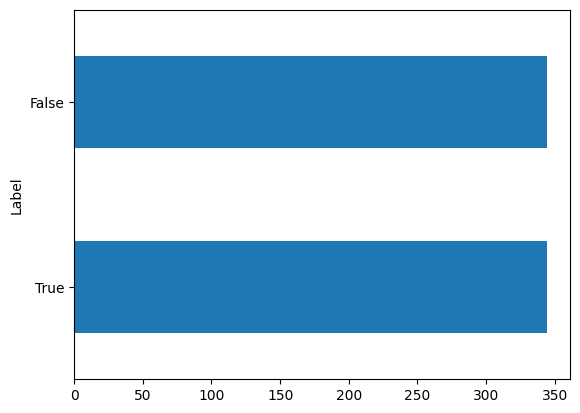

In [4]:
df['Label'].value_counts().plot(kind='barh')

### Articles Pipeline

In [5]:
def get_top_links(query, num_links=1):
    linksgot = []
    try:
        # Perform Google search and get the top links
        search_results = search(query, num_results=num_links)

        # Print the top links
        for i, link in enumerate(search_results, start=1):
            linksgot.append(link)
    except Exception as e:
        print(f"An error occurred: {e}")
    return linksgot


def get_title_and_content(search_query_results):
    article_titles = []
    article_content = []
    if search_query_results:
        for results in search_query_results:
            try:
                # Send a request to the URL and get the HTML content
                response = requests.get(results)
                soup = BeautifulSoup(response.content, 'lxml')

                currentp = ""
                # Scrape <p> tags
                p_tags = soup.find_all('p')
                for p in p_tags:
                    currentp += p.text
                article_content.append(currentp)

                currenth1 = ""
                # Scrape <h1> tags
                h1_tags = soup.find_all('h1')
                for h1 in h1_tags:
                    currenth1 += h1.text

                article_titles.append(currenth1)

            except Exception as e:
                print(f"An error occurred: {e}")
    return article_titles, article_content


# Get the titles and contents
def make_data(search_query_results):
    titles, contents = get_title_and_content(
        get_top_links(search_query_results))

    # Create a pandas DataFrame
    data = {'Title': titles, 'Content': contents}
    df = pd.DataFrame(data)
    return df

In [6]:
#To scrape headlines for the FactCC endpoint
def dataframegen(text_input):
    scraped_df = make_data(text_input)
    scraped_df.dropna(inplace=True)
    return scraped_df

In [7]:
#Load FactCC Model pipeline
pipe = pipeline(model="manueldeprada/FactCC", task="text-classification", max_length=512)

/opt/homebrew/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [8]:
def factCC(input_headline : str):
    scraped_df =  dataframegen(input_headline)

    # Convert the 'Content' column to strings
    scraped_df['Content'] = scraped_df['Content'].astype(str)

    # Sort the DataFrame based on the length of the strings in the 'Content' column
    scraped_df = scraped_df.sort_values(by='Content', key=lambda x: x.str.len(), ascending=False)

    # print(f"Title: {scraped_df['Content'][0][:100]}")

    if len(scraped_df) == 0 or not scraped_df['Content'][0] or '403 Forbidden' in scraped_df['Content'][0] or '403 Forbidden' in scraped_df['Title'][0] :
        #Could not retrieve articles related to headline, Most likely be a false claim as no information is found OR Scraper got blocked/forbidden(RARE)
        return False, "could not scrape content"

    scraped_content = (
    f"{scraped_df['Title'][0]} \n{scraped_df['Content'][0]}")
    
    # Perform text classification [source,claim]
    ans = pipe([[[scraped_content,input_headline]]], truncation=True, padding='max_length')
    if scraped_content is None:
        scraped_content = "Could not scrape content"
    if ans[0]['label'] == 'CORRECT':
        return True, scraped_content
    else:
        return False, scraped_content

In [9]:
model_decision, scraped_content = factCC(df['Headline'][0])
actual_decision = df['Label'][0]
print(model_decision,actual_decision)
if model_decision == actual_decision:
    print('Correct Decision')
else:
    print('Incorrect Decision')

True True
Correct Decision


In [10]:
df =df[71:]
df.shape

(617, 5)

In [ ]:
predictions = []
actuals = []
results = []
batch_size = 2
batch_size = 2

csv_filename = 'Pipeline_Article.csv'
processed_headlines = set()

# Check if CSV file already exists and load processed headlines
if os.path.exists(csv_filename):
    with open(csv_filename, 'r', newline='', encoding='utf-8') as csvfile:
        csvreader = csv.reader(csvfile, delimiter='|')
        next(csvreader)  # Skip header
        for row in csvreader:
            if len(row) < 2:  # Skip rows that may not have all columns
                continue
            headline = row[1]
            processed_headlines.add(headline)

try:
    # Open the CSV file for writing with '|' as the delimiter
    with open(csv_filename, 'a', newline='', encoding='utf-8') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter='|')
        if not processed_headlines:
            csvwriter.writerow(['Index', 'Headline', 'Scraped Content', 'Model Decision', 'Actual Decision'])
        
        # Iterate over each row in the dataframe with tqdm for progress
        for index, row in tqdm(df.iterrows(), total=len(df)):
            try:
                headline = row['Headline']
                if headline in processed_headlines:
                    print(f"Skipping already processed headline: {headline}")
                    continue
                
                model_decision, scraped_content = factCC(headline)
                
                # Convert scraped content to a single line
                scraped_content_single_line = ' '.join(scraped_content.splitlines()).strip().replace('|', ' ')
                
                actual_decision = row['Label']
                predictions.append(model_decision)
                actuals.append(actual_decision)
                
                results.append([index, headline, scraped_content_single_line, model_decision, actual_decision])
                time.sleep(5)  # Increase sleep time to avoid rate limiting
                
                # Write to CSV in batches of 10
                if len(results) % batch_size == 0:
                    csvwriter.writerows(results)
                    csvfile.flush()
                    os.fsync(csvfile.fileno())
                    results = []
            
            except Exception as e:
                print(f"Error processing row {index}: {str(e)}")
        
        # Write any remaining results
        if results:
            csvwriter.writerows(results)
            csvfile.flush()
            os.fsync(csvfile.fileno())

    # Calculate the metrics
    accuracy = accuracy_score(actuals, predictions)
    precision = precision_score(actuals, predictions, pos_label=True)
    recall = recall_score(actuals, predictions, pos_label=True)
    f1 = f1_score(actuals, predictions, pos_label=True)

    # Append the accuracy to the CSV file
    with open(csv_filename, 'a', newline='', encoding='utf-8') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter='|')
        csvwriter.writerow([])  # Add an empty row for separation
        csvwriter.writerow(['Metric', 'Value'])
        csvwriter.writerow(['Accuracy', accuracy])
        csvwriter.writerow(['Precision', precision])
        csvwriter.writerow(['Recall', recall])
        csvwriter.writerow(['F1 Score', f1])

    print(f'Results written to {csv_filename}')
    print(f'Final file size: {os.path.getsize(csv_filename)} bytes')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')

except Exception as e:
    print(f"An error occurred: {str(e)}")

finally:
    if os.path.exists(csv_filename):
        print(f"CSV file exists. Size: {os.path.getsize(csv_filename)} bytes")
    else:
        print("CSV file does not exist.")